# Email Assistant

In the following example, we will build an email assistant capable of:

1. Searching your emails + personal calendar
2. Writing emails and creating calendar events

To give greater control over the authoring flow for emails + calendar events, we will **separate** the LLM into separate flows:

![diagram](./img/diagram.png)

The **primary assistant** can query the emails and calendar and respond to requests.
If the user wants to write an email or create a calendar event, the assistant will automatically delegate to the **writing assistant** flow. This flow contains another prompt + LLM specifically designed organized for writing emails and creating calendar events. If the flow needs to "pop" the context back up to the primary assistant (when the user changes their mind, to search for additional information, etc.), it can easily do so via a function call.

Separating your assistant's "skills" into separate "flows" as sub-graphs or other cycles is one way you can design around limitations in LLMs' tool calling and intent detection capabilities. It is also a way to create more predictable user experiences and control for workflows that take actions. 

## Setup

Install langgraph, along with the other tool sused in this example (aiosqlite for an async sqlite memory checkpointer, OpenAI for the LLM).

In [1]:
%%capture --no-stderr
%pip install -U aiosqlite langgraph langchain_openai

Now configure your environment. We will set up tracing as well so you can inspect everything that's going on.

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
# Recommended
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Email Assistant Notebook"

## Create the Database

For the sake of this tutorial, we will create a `sqlite` email + calendar database to interact with (so you don't have to connect your personal email account).

Run the big code block below to create this test DB

In [3]:
import os
import sqlite3
from datetime import date, datetime, timedelta

CURRENT_TIME = datetime.now()
# Create a SQLite database file
db_file = "email-assistant.sqlite"
# First delete the file if it exists
if os.path.exists(db_file):
    os.remove(db_file)


conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# Create emails table
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS emails (
        id INTEGER PRIMARY KEY,
        sender TEXT NOT NULL,
        recipient TEXT NOT NULL,
        subject TEXT NOT NULL,
        body TEXT NOT NULL,
        timestamp DATE DEFAULT CURRENT_TIMESTAMP,
        thread_id INTEGER NOT NULL
    )
"""
)

# Create calendar_events table
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS calendar_events (
        id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        description TEXT,
        start_time TIMESTAMP NOT NULL,
        end_time TIMESTAMP NOT NULL
    )
"""
)

conn.commit()
conn.close()


def get_weekday(weekday: int, from_now: int = 1):
    if weekday < 0 or weekday > 6:
        raise ValueError("Weekday must be an integer between 0 and 6.")

    today = datetime.now()
    weekday += 7 * from_now
    days_until_weekday = weekday - today.weekday()
    target_time = today + timedelta(days=days_until_weekday)
    return target_time.replace(hour=0, minute=0, second=0, microsecond=0)


def insert_sample_data():
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    sample_emails = [
        (
            "vwp@langchain.com",
            "john@langchain.com",
            "Project Update",
            "Hi John, just wanted to give you an update on the user onboarding project. We've made significant progress over the past week and are on track to meet our deadlines. The development team has completed the core functionality, and we're now focusing on testing and bug fixes. Should be good for our public launch next thursday. Please let me know if you have any questions or concerns.",
            2026.9504965113408,
            9,
        ),
        (
            "jane@langchain.com",
            "vwp@langchain.com",
            "Meeting Agenda",
            "Here's the agenda for our meeting tomorrow: \n1. Project progress report\n2. Budget review\n3. Upcoming milestones\n4. Open discussion\nPlease come prepared with any updates or questions you may have.",
            12629.655208382988,
            8,
        ),
        (
            "vwp@langchain.com",
            "mike@langchain.com",
            "Quick Question",
            "Hey Mike, I had a quick question about the latest feature. How does the user authentication process work? I want to ensure we're following best practices for security. Could you provide a brief overview or point me to the relevant documentation? Thanks!",
            14788.927221524194,
            7,
        ),
        (
            "sarah@langchain.com",
            "vwp@langchain.com",
            "Design Review",
            "Please take a look at the attached design mockups for the new user interface. I'd appreciate your feedback on the layout, color scheme, and overall usability. Let me know if you have any suggestions for improvement. We'll need to finalize the designs by the end of the week.",
            16946.851204410043,
            6,
        ),
        (
            "vwp@langchain.com",
            "jane@langchain.com",
            "Re: Meeting Agenda",
            "Thanks for sending the agenda, looking forward to the meeting! I have a few additional points I'd like to discuss under the open discussion section. I'll bring them up during the meeting.",
            23223.11058470534,
            8,
        ),
        (
            "vwp@langchain.com",
            "team@langchain.com",
            "Team Offsite - Location Suggestions",
            "Hi everyone, as we start planning for next week's team offsite, I wanted to gather some location suggestions. Please reply with your ideas for a fun and productive offsite venue. Keep in mind that we'll need a space for team-building activities and breakout sessions. Looking forward to your ideas!",
            23274.643339498183,
            5,
        ),
        (
            "john@langchain.com",
            "vwp@langchain.com",
            "Re: Project Update",
            "Thanks for the update! It's great to hear that the project is progressing well. Keep up the excellent work, and don't hesitate to reach out if you need any support or resources from my end. I'm confident that we'll deliver a successful product.",
            29355.732141023844,
            9,
        ),
        (
            "mike@langchain.com",
            "vwp@langchain.com",
            "Re: Quick Question",
            "Hi there, the user authentication process is handled by our authentication middleware. It uses JSON Web Tokens (JWT) to secure the API endpoints. When a user logs in, the server generates a JWT that contains the user's ID and role. This token is then sent back to the client and must be included in the headers of all subsequent requests. The server verifies the token's validity and extracts the user information to authorize access to protected routes. You can find more details in the authentication docs: [link to docs]. Let me know if you have any other questions!",
            37540.59302416795,
            7,
        ),
        (
            "jane@langchain.com",
            "vwp@langchain.com",
            "Re: Team Offsite - Location Suggestions",
            "I suggest we consider the Green Valley Resort for our offsite. It offers a great mix of outdoor activities and comfortable meeting spaces. They have a team-building ropes course, hiking trails, and a spacious conference room for our breakout sessions. Plus, the hotel is only a 30-minute drive from the office, so it's convenient for everyone.",
            39319.93966189623,
            5,
        ),
        (
            "vwp@langchain.com",
            "sarah@langchain.com",
            "Re: Design Review",
            "Thanks for sharing the design mockups, Sarah. Overall, I think the layout looks clean and intuitive. The color scheme is visually appealing and aligns well with our brand guidelines. One suggestion I have is to make the call-to-action buttons a bit more prominent. Perhaps we could use a bolder color or increase the size slightly. Other than that, great work! Let's discuss any final tweaks during our next design meeting.",
            40936.43634580034,
            6,
        ),
        (
            "mike@langchain.com",
            "vwp@langchain.com",
            "Feature Request",
            "Hey, I've been thinking about a new feature that could enhance our product's usability. What do you think about adding a personalized dashboard for each user? It could display relevant metrics, shortcuts to frequently used actions, and customized recommendations based on their usage patterns. I believe this would greatly improve the user experience and increase engagement. Let me know your thoughts, and if you think it's worth exploring further, I can put together a more detailed proposal.",
            44667.12161848089,
            4,
        ),
        (
            "noreply@marriot.com",
            "vwp@langchain.com",
            "Reservation Confirmation",
            "Dear vwp, your reservation at the Orange Valley Resort has been confirmed. You're all set for the team offsite next week. If you have any special requests or need assistance during your stay, please don't hesitate to contact us. We look forward to welcoming you to the resort!",
            44863.92658515163,
            10,
        ),
        (
            "vwp@langchain.com",
            "mike@langchain.com",
            "Re: Feature Request",
            "Hi Mike, thanks for bringing up the personalized dashboard idea. I think it's a great suggestion and could definitely add value to our product. It aligns with our goal of providing a more tailored and efficient user experience. Please go ahead and put together a detailed proposal outlining the key features, benefits, and potential implementation timeline. We can review it together and discuss the next steps. Good thinking!",
            45863.92658515163,
            4,
        ),
        (
            "sarah@langchain.com",
            "vwp@langchain.com",
            "Design Assets",
            "Hey, I've uploaded the final design assets to our shared drive. You'll find the updated mockups, icons, and style guide in the 'Design' folder. Please let me know if you have any trouble accessing the files or if you need anything else from my end. I'm excited to see these designs come to life in the development phase!",
            47144.391577314855,
            3,
        ),
        (
            "vwp@langchain.com",
            "sarah@langchain.com",
            "Re: Design Assets",
            "Thanks, Sarah! I appreciate you putting together the final design assets. I'll make sure to share them with the development team so they can start implementing the new UI. Great collaboration on this project!",
            49196.91606513955,
            3,
        ),
        (
            "john@langchain.com",
            "vwp@langchain.com",
            "Budget Approval",
            "I've reviewed the budget proposal for the upcoming quarter, and everything looks good. I appreciate the detailed breakdown of expenses and the justification for each line item. I'm happy to approve the budget as is. Please proceed with allocating the resources accordingly and keep me updated on the progress. If you need any further support or have any questions, don't hesitate to reach out. Great job on putting together a comprehensive proposal!",
            51747.2714351549,
            2,
        ),
        (
            "vwp@langchain.com",
            "john@langchain.com",
            "Re: Budget Approval",
            "Thank you for the quick approval, John! I'm glad the budget proposal met your expectations. I'll start allocating the resources and keep you informed of our progress throughout the quarter. If any adjustments are needed along the way, I'll be sure to communicate them to you promptly. Thanks again for your support!",
            54524.51894416319,
            2,
        ),
        (
            "jane@langchain.com",
            "vwp@langchain.com",
            "Team Offsite - Agenda",
            "As a follow-up to the location suggestions, I've drafted an agenda for our team offsite. Please take a look and let me know if you have any feedback or additional items you'd like to include:\n\nDay 1:\n- 9:00 AM: Arrival and breakfast\n- 10:00 AM: Team-building activity\n- 12:00 PM: Lunch\n- 1:30 PM: Strategic planning session\n- 4:00 PM: Break\n- 4:30 PM: Departmental updates\n- 6:00 PM: Dinner\n\nDay 2:\n- 9:00 AM: Breakfast\n- 10:00 AM: Skill-sharing workshops\n- 12:00 PM: Lunch\n- 1:30 PM: Hackathon\n- 4:30 PM: Presentations and wrap-up\n- 6:00 PM: Departure\n\nLooking forward to a productive and enjoyable offsite!",
            56522.321453306475,
            5,
        ),
        (
            "vwp@langchain.com",
            "jane@langchain.com",
            "Re: Team Offsite - Agenda",
            "Thanks for putting together the agenda, Jane. It looks well-structured and covers all the key aspects we discussed. I particularly like the idea of having skill-sharing workshops and a hackathon. It will be a great opportunity for cross-functional collaboration and learning. One suggestion: How about we add a short session on the morning of Day 2 to reflect on the previous day's insights and set some actionable goals? Other than that, the agenda looks perfect. I'm excited for the offsite!",
            72383.00036845915,
            5,
        ),
        (
            "mike@langchain.com",
            "vwp@langchain.com",
            "Personalized Dashboard Proposal",
            "As promised, I've put together a detailed proposal for the personalized dashboard feature. The proposal outlines the key benefits, user stories, and a high-level implementation plan. I've also included some rough mockups to visualize the concept. You can find the document attached to this email. Please review it and let me know your thoughts. If you have any questions or need further clarification, I'm happy to discuss it in more detail. Looking forward to your feedback!",
            75351.97314700157,
            4,
        ),
        (
            "vwp@langchain.com",
            "mike@langchain.com",
            "Re: Personalized Dashboard Proposal",
            "Thanks for the comprehensive proposal, Mike. I've gone through it, and I must say, I'm impressed with the level of detail and thought you've put into it. The user stories clearly demonstrate the value this feature would bring, and the implementation plan seems feasible. I particularly like the idea of using machine learning to provide personalized recommendations. Let's schedule a meeting with the product team to discuss the next steps and prioritize this feature in our roadmap. Great work!",
            77364.60138980031,
            4,
        ),
        (
            "sarah@langchain.com",
            "vwp@langchain.com",
            "Design System Update",
            "I wanted to give you a heads up that I've been working on updating our design system documentation. I've reorganized the content, added more examples, and created a new section on accessibility guidelines. The updated documentation will make it easier for the team to maintain consistency and build accessible interfaces. I'll be sharing the updated design system with the team next week and will schedule a walkthrough session to highlight the changes. Let me know if you have any specific areas you'd like me to focus on during the session.",
            78357.40261179926,
            1,
        ),
        (
            "vwp@langchain.com",
            "sarah@langchain.com",
            "Re: Design System Update",
            "That's fantastic news, Sarah! I'm thrilled to hear about the updates to our design system documentation. Accessibility is a crucial aspect of our products, and having clear guidelines will be invaluable for the team. I appreciate you taking the initiative to improve the design system. During the walkthrough session, it would be great if you could emphasize the importance of accessibility and provide some practical examples of how we can implement the guidelines in our designs. I'm looking forward to seeing the updated documentation and attending the session. Thank you for your hard work!",
            80771.59963045195,
            1,
        ),
        (
            "john@langchain.com",
            "vwp@langchain.com",
            "Quarterly Goals Review",
            "As we approach the end of the quarter, I wanted to touch base with you regarding our team's goals. I've been reviewing the progress reports, and I'm pleased to see that we're on track to meet most of our objectives. However, I noticed that there are a couple of areas where we're slightly behind. Specifically, the user onboarding project and the API documentation update. I'd like to schedule a meeting with you to discuss these areas and identify any roadblocks or support needed to get them back on track. Please let me know your availability for early next week. Keep up the great work!",
            90343.21155814404,
            0,
        ),
        (
            "vwp@langchain.com",
            "john@langchain.com",
            "Re: Quarterly Goals Review",
            "Thanks for reaching out, John. I appreciate you taking the time to review our team's progress. You're right, we have made significant strides towards achieving our quarterly goals. Regarding the user onboarding project and the API documentation update, we did face some challenges that caused slight delays. I've been working with the respective teams to address these issues and have some ideas on how we can get back on track. I'm available for a meeting early next week to discuss this in detail. How about Tuesday at 10 AM? Let me know if that works for you, and I'll send out a calendar invite. Looking forward to our discussion!",
            92185.16558031109,
            0,
        ),
        (
            "jane@langchain.com",
            "vwp@langchain.com",
            "Re: Team Offsite - Agenda",
            "Thanks for your feedback on the agenda! I like your suggestion of adding a reflection and goal-setting session on Day 2. It will be a great way to start the day and ensure we're aligned on our next steps. I've updated the agenda to include this session. Here's the revised timeline for Day 2:\n\nDay 2:\n- 9:00 AM: Breakfast\n- 9:30 AM: Reflection and goal-setting\n- 10:30 AM: Skill-sharing workshops\n- 12:00 PM: Lunch\n- 1:30 PM: Hackathon\n- 4:30 PM: Presentations and wrap-up\n- 6:00 PM: Departure\n\nPlease let me know if you have any further suggestions. I'll be sending out the finalized agenda to the team by the end of the day.",
            97154.82647124105,
            5,
        ),
        (
            "vwp@langchain.com",
            "jane@langchain.com",
            "Re: Team Offsite - Agenda",
            "The updated agenda looks great, Jane! The reflection and goal-setting session will be a valuable addition. I don't have any further suggestions at this point. I think we have a solid plan for the offsite. Please go ahead and send out the finalized agenda to the team. I appreciate all your efforts in organizing this event. It's going to be a fantastic opportunity for our team to bond, learn, and strategize together. If there's anything else I can assist with in the lead-up to the offsite, just let me know. Thanks again for your excellent work!",
            99099.46774452076,
            5,
        ),
        (
            "mike@langchain.com",
            "vwp@langchain.com",
            "Re: Personalized Dashboard Proposal",
            "I'm glad you found the proposal comprehensive and insightful. Your feedback means a lot to me. I agree that prioritizing this feature in our roadmap is crucial, given its potential impact on userengagement and satisfaction. I've scheduled a meeting with the product team for next Wednesday at 2 PM to discuss the next steps. I've also invited you to the meeting so that you can provide your valuable input and help guide the discussion. In the meantime, I'll start gathering more data on user behavior and preferences to inform the implementation process. Looking forward to collaborating on this exciting project!",
            100583.02071204889,
            4,
        ),
        (
            "vwp@langchain.com",
            "mike@langchain.com",
            "Re: Personalized Dashboard Proposal",
            "Thanks for scheduling the meeting with the product team, Mike. I appreciate you taking the lead on this initiative. I've accepted the meeting invite and look forward to participating in the discussion. Your idea to gather more data on user behavior and preferences is spot-on. It will help us make informed decisions and prioritize the features that will have the most significant impact. If you need any assistance or resources for the data collection process, please don't hesitate to reach out. I'm excited to see how this project evolves and contributes to our product's success. Keep up the excellent work!",
            111271.76779519916,
            4,
        ),
        (
            "sarah@langchain.com",
            "vwp@langchain.com",
            "Re: Design System Update",
            "I'm thrilled to hear that you're excited about the updates to our design system documentation. Accessibility is indeed a top priority for our team, and I'm glad we're taking steps to make it an integral part of our design process. During the walkthrough session, I'll make sure to highlight the importance of accessibility and provide practical examples of how we can implement the guidelines. I'll also leave time for questions and discussions to ensure everyone is on the same page. I'm planning to schedule the session for next Thursday afternoon. I'll send out a calendar invite with the specific details. Please let me know if you have any other suggestions or topics you'd like me to cover.",
            120272.93742610891,
            1,
        ),
    ]
    updated_emails = []
    for email in sample_emails:
        updated_emails.append(
            email[:4]
            + ((CURRENT_TIME - timedelta(seconds=email[4])).isoformat(),)
            + email[5:]
        )

    cursor.executemany(
        "INSERT INTO emails (sender, recipient, subject, body, timestamp, thread_id) VALUES (?, ?, ?, ?, ?, ?)",
        updated_emails,
    )

    offsite_times = [
        get_weekday(4) + timedelta(hours=9),
        get_weekday(6) + timedelta(hours=15),
    ]
    launch_time = get_weekday(3) + timedelta(hours=18)

    # Insert sample events
    sample_events = [
        (
            "Team Meeting",
            "Weekly team sync",
            CURRENT_TIME + timedelta(days=1),
            CURRENT_TIME + timedelta(days=1, hours=1),
        ),
        (
            "Project Kickoff",
            "Kickoff meeting for user onboarding project",
            CURRENT_TIME + timedelta(days=3, hours=9),
            CURRENT_TIME + timedelta(days=3, hours=10),
        ),
        (
            "Flight UA 123",
            "Flight from SFO to ORD for the company offsite.",
            offsite_times[0] - timedelta(hours=4),
            offsite_times[0] - timedelta(hours=1),
        ),
        (
            "Company Offsite",
            "Annual company offsite event at the Orange Valley Resort",
            offsite_times[0],
            offsite_times[1],
        ),
        (
            "Flight UA 456",
            "Flight back from ORD to SFO",
            offsite_times[1] + timedelta(hours=3),
            offsite_times[1] + timedelta(hours=7),
        ),
        (
            "Flight AA 789",
            "Flight to Mike's wedding! Don't forget the gift!",
            get_weekday(4) + timedelta(days=7, hours=15),
            get_weekday(4) + timedelta(days=7, hours=19),
        ),
        (
            "Launch Party",
            "Celebrate the (hopefully) successful launch of the user onboarding project!",
            launch_time,
            launch_time + timedelta(hours=3),
        )
    ]

    for i in range(50):
        event_date = CURRENT_TIME + timedelta(days=i)
        desc = f"Description for event {i+1}"
        if i == 24:
            desc = "This is a top secret event. Don't forget the secret code: pikasaurus rex."
        sample_events.append(
            (
                f"Event {i+1}",
                desc,
                event_date.strftime("%Y-%m-%d 09:00:00"),
                event_date.strftime("%Y-%m-%d 10:00:00"),
            )
        )

    cursor.executemany(
        "INSERT INTO calendar_events (title, description, start_time, end_time) VALUES (?, ?, ?, ?)",
        sample_events,
    )
    conn.commit()
    conn.close()


insert_sample_data()


## Create tools

Tools define the interface between the assistant and our system's resources.

In [4]:
import sqlite3
from datetime import date, datetime
from typing import Optional

from langchain_core.runnables.config import ensure_config
from langchain_core.tools import tool


@tool
async def search_emails(
    queries: Optional[list[str] | str] = None,
    sender: Optional[str] = None,
    recipient: Optional[str] = None,
    start_date: Optional[date | datetime] = None,
    end_date: Optional[date | datetime] = None,
    thread_id: Optional[int] = None,
) -> dict:
    """Search emails based on the given queries and optional filters.
    queries: The search queries to match against the subject or body of the email. The queries are joined with an OR condition.
    sender: A substring to match against the sender email address.
        If you don't know the email domain, just search by username.
    recipient: A substring to match against the recipient email address.
        If you don't know the email domain, just search by username.
    start_date: The start date for the search range (inclusive, but be lenient on bounds).
    end_date: The end date for the search range (exclusive)
    thread_id: The thread ID of the email thread."""
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    conditions = []
    params = []

    if queries:
        if isinstance(queries, str):
            queries = [queries]
        query_conditions = []
        for query in queries:
            for exact in query.split('"'):
                for tok in exact.split():
                    tok = tok.replace("*", "%")
                    query_conditions.append(
                        "(subject LIKE ? OR body LIKE ? OR sender LIKE ? OR recipient LIKE ?)"
                    )
                    params.extend([f"%{tok}%", f"%{tok}%", f"%{tok}%", f"%{tok}%"])
        conditions.append(f"({' OR '.join(query_conditions)})")

    if sender:
        conditions.append("sender LIKE ?")
        params.append(f"%{sender}%")
    if recipient:
        conditions.append("recipient LIKE ?")
        params.append(f"%{recipient}%")
    if start_date:
        conditions.append("timestamp >= ?")
        params.append(start_date)
    if end_date:
        conditions.append("timestamp < ?")
        params.append(end_date)
    if thread_id:
        conditions.append("thread_id = ?")
        params.append(thread_id)

    where_clause = " AND ".join(conditions)
    if where_clause:
        where_clause = " WHERE " + where_clause
    cursor.execute(f"SELECT * FROM emails{where_clause}", params)
    results = cursor.fetchall()
    conn.close()
    keys = [column[0] for column in cursor.description]
    return {
        "results": [dict(zip(keys, row)) for row in results],
        "count": len(results),
    }


@tool
async def search_calendar_events(
    queries: Optional[list[str] | str] = None,
    start_date: Optional[datetime | date] = None,
    end_date: Optional[datetime | date] = None,
) -> dict:
    """Search calendar events based on the given queries and optional date range.

    Args:
        queries (list[str] | str | null): The search queries to match against the title or description of the event. The queries are joined with an OR condition.
            Examples:
                - queries: ["standup", "walk the dog"] (search for events containing either of these terms)
                - queries: "team offsite" (search for events containing the exact phrase "team offsite")
            Importantly, is NOT a comma separated list.

        start_date (datetime | date | null): The start time for the search range (inclusive).
        end_date (datetime | date | null): The end time for the search range (exclusive).
    """
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    conditions = []
    params = []

    if queries:
        if isinstance(queries, str):
            queries = [queries]
        query_conditions = []
        for query in queries:
            for exact in query.split('"'):
                for tok in exact.split():
                    tok = tok.replace("*", "%")
                    query_conditions.append("(title LIKE ? OR description LIKE ?)")
                    params.extend([f"%{tok}%", f"%{tok}%"])
        conditions.append(f"({' OR '.join(query_conditions)})")

    if start_date:
        conditions.append("start_time >= ?")
        params.append(start_date)
    if end_date:
        conditions.append("end_time < ?")
        params.append(end_date)

    where_clause = " AND ".join(conditions)
    if where_clause:
        where_clause = " WHERE " + where_clause
    cursor.execute(
        f"SELECT title, description, start_time, end_time FROM calendar_events{where_clause}",
        params,
    )
    results = cursor.fetchall()
    conn.close()
    keys = [column[0] for column in cursor.description]
    return {
        "results": [dict(zip(keys, row)) for row in results],
        "count": len(results),
    }


@tool
async def create_calendar_event(
    title: str, description: str, start_time: datetime, end_time: datetime
) -> str:
    """Create a calendar event with the given details."""
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    cursor.execute(
        "INSERT INTO calendar_events (title, description, start_time, end_time) VALUES (?, ?, ?, ?)",
        (title, description, start_time, end_time),
    )
    conn.commit()
    conn.close()
    return f"Calendar event created: {title} from {start_time} to {end_time}."


@tool
async def send_email(
    to: str, subject: str, body: str, thread_id: Optional[int] = None
) -> str:
    """Send an email with the given details."""
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    config = ensure_config()
    user_id = config["configurable"]["user_id"]
    if thread_id is None:
        # Fetch the maximum thread ID and increment it by 1
        cursor.execute("SELECT COALESCE(MAX(thread_id), 0) + 1 FROM emails")
        thread_id = cursor.fetchone()[0]
    cursor.execute(
        "INSERT INTO emails (sender, recipient, subject, body, thread_id) VALUES (?, ?, ?, ?, ?)",
        (user_id, to, subject, body, thread_id),
    )
    conn.commit()
    conn.close()
    return f"Email sent to {to} with subject '{subject}'."


## Define Graph

Our graph has two main "loops" around the **assistant** and **write_assistant** nodes.

![diagram](./img/diagram.png)

The **assistant** can "read" information but isn't permitted to "write." To assist in **writing** tasks, it delegates control to the **write_assistant**. 

The **write_assistant** has a more domain-specific prompt and set of tools to let it send emails and calendar events. The graph is also compiled with `interrupt_before` to explicitly require user confirmation (or rejection) of the action.

As usual, let's first define the `State`. This time, our state contains two fields: `messages`, and `dialog_state`. The `messages` contain the chat messages for the LLM. The `dialog_state` field is a shorthand accessor to see which flow should have control.

In [5]:
from typing import Annotated, Literal, Optional
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

def update_dialog_stack(
    left: list[Literal["assistant", "writer"]],
    right: Optional[Literal["assistant", "writer", "pop"]],
) -> list[Literal["assistant", "writer"]]:
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    dialog_state: Annotated[list[Literal["assistant", "writer"]], update_dialog_stack]

#### Define Assistant

Now we'll define the assistants. Define the prompts, llms, and additional functions to call to let the assistants route between each sub-graph.

In [6]:
from datetime import datetime
from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langgraph.graph import END, StateGraph

from langgraph.prebuilt import ToolNode, tools_condition

llm = ChatOpenAI(model="gpt-4-turbo")

safe_tools = [search_emails, search_calendar_events]
sensitive_tools = [create_calendar_event, send_email]
sensitive_tool_names = {t.name for t in sensitive_tools}


class WriteAssistant(BaseModel):
    f"""Transfers work to an expert assistant with access to the following tools: {', '.join(list(sensitive_tool_names))}.
    
    If you invoke this tool, refrain from using any other tools until the writing assistant has completed the task."""

    request: str = Field(
        description="Any necessary followup questions the writing assistant should clarify before proceeding."
    )


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a proactive and helpful personal assistant. "
            "Utilize the available tools to search for information and perform actions to assist the user effectively. "
            "For straightforward queries, directly respond or use the tools to find the most relevant information and provide a concise answer. "
            "If you don't know the answer immediately, query the available tools to find the information. Rather than saying something like 'it looks like there are no details about X', actually "
            "double check your bases to ensure you're not missing anything. "
            "If the user's request requires actions like sending emails, creating calendar events, or writing content, immediately delegate these tasks to the {delegate_name} tool for optimal results."
            "\nWhen searching emails or calendars to find relevant information for the user's query, do so proactively without asking for permission each time. "
            " If you don't know the answer, search first to save the user's time. "
            "\nIf your tool calls return an error or your search returns empty, try alternative methods or rephrase your search before concluding that the information is unavailable. "
            "\n<user_info>\n{user_info}\n</user_info>\n"
            "<current_time>{time}</current_time>",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=lambda: datetime.now(), delegate_name=WriteAssistant.__name__)


tools = safe_tools + [WriteAssistant]
assistant_runnable = prompt | llm.bind_tools(tools).with_retry()

followup_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful personal assistant. "
            "You provide responses by applying your learned reasoning to the informational tools at your disposal, "
            "and you inform the user when this limitation is relevant to their query, asking follow-up questions where necessary when taking actions. "
            "For simple questions, provide concise answers; for more complex inquiries, offer thorough explanations. "
            "You assist with a wide range of tasks, including email writing, scheduling, research, analysis, math, coding, and other personal matters."
            "\nWhen seeking information to answer a query, feel free to use available tools without requiring user confirmation. "
            "For example, if the user asks, 'What's the weather forecast for tomorrow?', you can directly use a weather API or search tool to find the information and provide a concise answer."
            "\nHowever, for actions that could impact the user's personal data or external services, like sending emails or creating calendar events, always ask for explicit confirmation before proceeding. "
            "For instance, if the user requests, 'Please schedule a meeting with John for next Tuesday at 2 PM,' respond with something like: 'How would you like to name your calendar event with John on [date] at 2 PM?'"
            "\nSimilarly, if the user says, 'Send an email to my boss letting her know I'll be out of the office next week,' reply with: 'Certainly. To ensure I have the correct information, could you please provide your boss's email address and confirm the specific dates you'll be out of the office? I'll send you the draft for approval before sending it to your boss.'"
            "\nIf tools error out or searches return empty, try alternate methods. Break down complex tasks into manageable steps and seek the user's approval for your proposed plan."
            "\nIf the user asks you to use a tool that you don't have access to, Escalate the task to the main assistant, who can re-route the dialog based on the user's needs."
            "Communicate in a friendly, professional manner, adapting your tone to the user's preferences. "
            "When offering facts, opinions, or recommendations, cite reputable sources to support your statements when possible."
            "<user_info>\n{user_info}\n</user_info>\n"
            "\n<current_time>{time}</current_time>",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=lambda: datetime.now())


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


followup_runnable = (
    followup_prompt
    | llm.bind_tools([CompleteOrEscalate] + sensitive_tools).with_retry()
)


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    async def acall(self, state: State, config: RunnableConfig):
        user_id = config["configurable"]["user_id"]
        return {
            "messages": await self.runnable.ainvoke(
                {**state, "user_info": f"<user_id>{user_id}</user_id>"}
            )
        }


async def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

#### Define `StateGraph`

In [7]:
builder = StateGraph(State)
# You can start at any of the "scoped" assistants
def pick_starting_point(state: State) -> str:
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "assistant"
    return dialog_state[-1]

builder.set_conditional_entry_point(pick_starting_point)

# First, define the assistant's components
builder.add_node("assistant", Assistant(assistant_runnable).acall)
safe_tool_node = ToolNode(safe_tools)
builder.add_node(
    "assistant_tools",
    safe_tool_node.with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    ),
)

def route_assistant(state):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls and tool_calls[0]["name"] == WriteAssistant.__name__:  # noqa
        return "enter_write_sequence"
    return "assistant_tools"

builder.add_conditional_edges(
    "assistant",
    route_assistant,
    {
        "enter_write_sequence": "enter_write_sequence",
        "assistant_tools": "assistant_tools",
        END: END,
    },
)
builder.add_edge("assistant_tools", "assistant")

# Now define the writing assistant's components

async def enter_write_sequence(state: State) -> dict:
    """Push the dialog stack and delegate work to the writing assistant."""
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
    return {
        "messages": [
            # The AI endpoints expect a tool response immediately after the tool call
            ToolMessage(
                content="Delegating work to the writing assistant. Use your provided tools to assist the user with their request."
                " Once you have enough information, perform the necessary actions to complete the task."
                " Note that you will see other tools used in the conversation. Remember you only have access to the tools provided in the prompt.",
                tool_call_id=tool_call_id,
            )
        ],
        "dialog_state": "write_assistant",
    }

builder.add_node("enter_write_sequence", enter_write_sequence)
builder.add_node("write_assistant", Assistant(followup_runnable).acall)
builder.add_edge("enter_write_sequence", "write_assistant")
sensitive_tool_node = ToolNode(sensitive_tools)
builder.add_node(
    "writer_sensitive_tools",
    sensitive_tool_node.with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    ),
)

async def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        messages.append(
            ToolMessage(
                content="Resuming dialog with the assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }

builder.add_node("leave_write_sequence", pop_dialog_state)

def route_writer(state):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_write_sequence"
    return "writer_sensitive_tools"
builder.add_conditional_edges(
    "write_assistant",
    route_writer,
    {
        "writer_sensitive_tools": "writer_sensitive_tools",
        "leave_write_sequence": "leave_write_sequence",
        END: END,
    },
)
builder.add_edge("writer_sensitive_tools", "write_assistant")
builder.add_edge("leave_write_sequence", "assistant")


memory = AsyncSqliteSaver.from_conn_string(":memory:")
graph = builder.compile(
    checkpointer=memory, 
    # We want to ensure the user gives explicit permission before any email
    # or calendar event is made
    interrupt_before=["writer_sensitive_tools"]
)

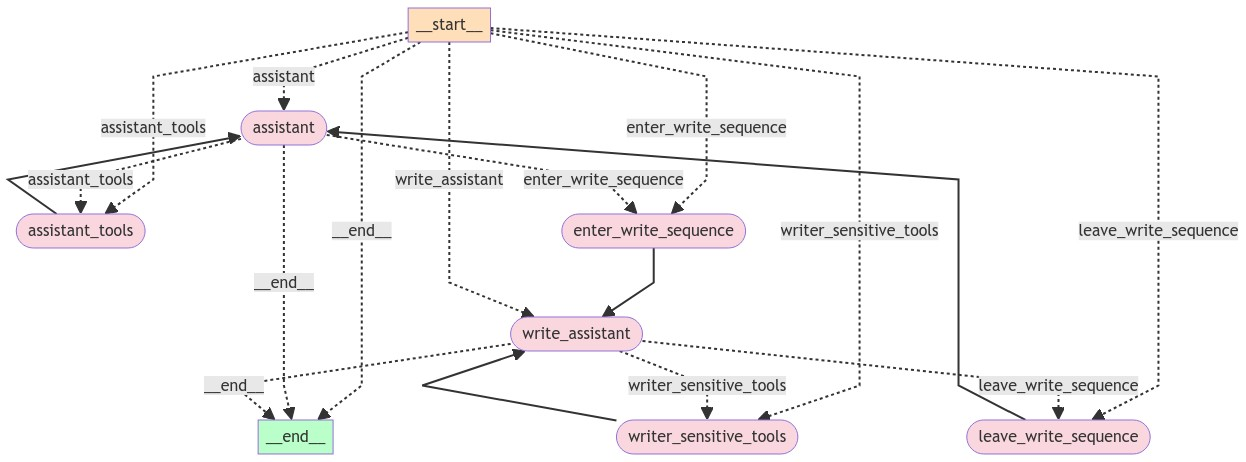

In [8]:
from IPython.display import display, Image
try:
    display(Image(graph.get_graph(add_condition_nodes=False).draw_mermaid_png()))
except:
    # This requires some extra dependencies, so we will catch errors here
    pass

Now it's time to use the assistant! Since it uses a checkpointer, it can retain memories across invocations.

In [9]:
import uuid

questions = [
    "When is the offsite?",
    "What time's my flight?",
    "which airline again?",
    "where are we staying?",
    "create an event with Sachin at the hotel bar 6pm on Friday",
    "send him an email reminder",
]

thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        "user_id": "vwp@langchain.com",
        "thread_id": thread_id,
    }
}
for question in questions:
    print("="*40 + "User" + "="*40)
    print("User: ", question)
    result = await graph.ainvoke(
        {"messages": ("user", question)},
        config,
    )
    snapshot = await graph.aget_state(config)
    if snapshot.next:
        # We have an interrupt! The agent is
        # trying to create a cal event or send an email.
        # We can approve or deny it
        result["messages"][-1].pretty_print()
        user_input = input(
            "Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed."
        )
        if user_input.strip() == "y":
            # Just continue
            result = await graph.ainvoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by 
            # providing instructions on the requested changes / change of mind
            await graph.ainvoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=result["messages"][-1].tool_calls[0]["id"],
                            content=f"Tool call denied by user. Reasoning: '{user_input}'",
                        )
                    ]
                },
                config
            )

    result["messages"][-1].pretty_print()


========================================User========================================
User:  When is the offsite?
================================== Ai Message ==================================

The company offsite is scheduled from May 3rd at 9:00 AM to May 5th at 3:00 PM. It will be held at the Orange Valley Resort.
========================================User========================================
User:  What time's my flight?
================================== Ai Message ==================================

Your flight, UA 123, is scheduled to depart from SFO to ORD on May 3rd at 5:00 AM and will arrive at 8:00 AM.
========================================User========================================
User:  which airline again?
================================== Ai Message ==================================

Your flight is with United Airlines (flight number UA 123).
========================================User========================================
User:  where are we staying?
====

Do you approve of the above actions? Type 'y' to continue; otherwise, explain your requested changed. y


================================== Ai Message ==================================

I've created the calendar event for your meeting with Sachin at the hotel bar. It's scheduled for May 5th from 6:00 PM to 7:00 PM at the Orange Valley Resort.
========================================User========================================
User:  send him an email reminder
================================== Ai Message ==================================

Could you please provide Sachin's email address? Also, let me know if there's any specific message or details you'd like to include in the email reminder.


In [10]:
result = await graph.ainvoke(
    {"messages": ("user", "His email is sachin at langchain.com")},
    config,
)
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here's a draft for the email reminder to Sachin:

---

Subject: Reminder: Meeting at Hotel Bar on May 5th

Hi Sachin,

I hope this message finds you well. Just a quick reminder about our meeting scheduled at the hotel bar during the company offsite. Here are the details:

- **Date:** Friday, May 5th
- **Time:** 6:00 PM to 7:00 PM
- **Location:** Hotel Bar, Orange Valley Resort

Looking forward to catching up!

Best regards,

[Your Name]

---

Please let me know if you'd like to adjust the content or send it as it is.


In [11]:
user_input = "You need to include my name (Will) - also no need to be so formal"
snapshot = await graph.aget_state(config)
if snapshot.next:
    # If the assistant directly tried to send, we have added an interrupt
    result = await graph.ainvoke(
        {
            "messages": [
                ToolMessage(
                    tool_call_id=result["messages"][-1].tool_calls[0]["id"],
                    content=f"Tool call denied by user. Reasoning: '{user_input}'",
                )
            ]
        },
        config
    )
else:
    # If the assistant chose to respond since it isn't ready to send, we can respond directly
    result = await graph.ainvoke(
        {
            "messages": [
                ("user", user_input)
            ]
        },
        config
    )
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here's the revised email reminder for Sachin:

---

Subject: Catch-Up at the Hotel Bar on May 5th

Hi Sachin,

Just a heads-up about our catch-up at the hotel bar on May 5th from 6:00 PM to 7:00 PM at the Orange Valley Resort. Looking forward to it!

Cheers,
Will

---

Shall I go ahead and send this email to Sachin at sachin@langchain.com?


In [12]:
user_input = "Looks good. Send away!"
snapshot = await graph.aget_state(config)
if snapshot.next:
    # If the assistant directly tried to send, we have added an interrupt
    result = await graph.ainvoke(
        {
            "messages": [
                ToolMessage(
                    tool_call_id=result["messages"][-1].tool_calls[0]["id"],
                    content=f"Tool call denied by user. Reasoning: '{user_input}'",
                )
            ]
        },
        config
    )
else:
    # If the assistant chose to respond since it isn't ready to send, we can respond directly
    result = await graph.ainvoke(
        {
            "messages": [
                ("user", user_input)
            ]
        },
        config
    )
result["messages"][-1].pretty_print()

================================== Ai Message ==================================




In [13]:
snapshot = await graph.aget_state(config)
if snapshot.next:
    # If the assistant directly tried to send, we have added an interrupt
    result = await graph.ainvoke(
        None,
        config
    )
result["messages"][-1].pretty_print()

================================== Ai Message ==================================

The email reminder has been sent to Sachin. If there's anything else you need, just let me know!
